
### Imports

In [1]:
%pylab inline
import healpy
from scipy.interpolate import InterpolatedUnivariateSpline

Populating the interactive namespace from numpy and matplotlib


### Options

In [2]:
Nside = 128
lmax = 3*Nside-1
print("lmax: %d"%lmax)

# Binning parameters
dl = 10 # width
Nl = 5 # number
min_l = 5 # minimum
print("binned lmax: %d"%(min_l+dl*Nl))

# Number of random iterations
N_it = 20

# Number of simulations to use for testing
N_sim = 500

# Whether to include bins only partially satisfying triangle conditions
include_partial_triangles = False

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/projects/QUIJOTE/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

lmax: 383
binned lmax: 55


### Fiducial Power and Noise Spectrum

In [3]:
from classy import Class
cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)
l_arr,m_arr = healpy.Alm.getlm(lmax)

# Run CLASS
cosmo.set({'output':'tCl,lCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute signal C_ell
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = Cl_dict['tt']*cosmo.T_cmb()**2

# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
thetaFWHM = 5./60.*np.pi/180. # in radians
Nl_th = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))

# Interpolate to all ell, m grid
Cl_th_interp = InterpolatedUnivariateSpline(l,Cl_th)
Nl_th_interp = InterpolatedUnivariateSpline(l,Nl_th)
Cl_th_lm = Cl_th_interp(l_arr)
Nl_th_lm = Nl_th_interp(l_arr)

# Zero out ell = 0 and ell = 1
Cl_th_lm[l_arr<2] = 0.
Nl_th_lm[l_arr<2] = 0.

In [4]:
# define separable reduced bispectrum input
include_synthetic_b = False
include_synthetic_t = False
b_input_fac = lambda l1: np.exp(-(l1-2)/40.)*2e-6

### Load mask

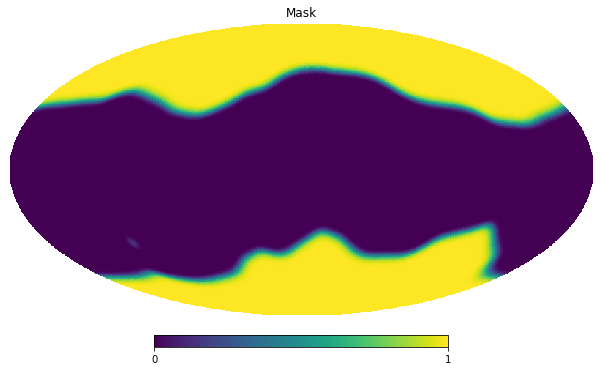

In [5]:
mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)
healpy.mollview(mask,title='Mask')

### Generate Synthetic Data with known $C_\ell$, $b_{\ell_1\ell_2\ell_3}$

**Bispectrum generation**
From Smith & Zaldarriaga (2006):
$$a_{\ell m} \to a_{\ell m}+\frac{1}{3}\nabla_{\ell m}T[C^{-1}_\ell a_{\ell m}]$$
with $\nabla_{\ell m}T[x]$ defined by
\begin{eqnarray}
    \frac{\partial T[a]}{\partial a^*_{\ell m}}&=&\frac{1}{2}b_{\ell\ell_2\ell_3}\mathcal{G}^{\ell\ell_2\ell_3}_{mm_2m_3}a_{\ell_2m_2}^*a_{\ell_3m_3}^*\\
    &=&\frac{1}{2}b_{\ell\ell_2\ell_3}\int d\hat{n} Y^*_{\ell m}(\hat n)Y^*_{\ell_2m_2}(\hat n)Y^*_{\ell_3m_3}(\hat n)a_{\ell_2m_2}^*a_{\ell_3m_3}^*
\end{eqnarray}
Assuming separable $b_{\ell_1\ell_2\ell_3}$, we can write
\begin{eqnarray}
    \frac{\partial T[a]}{\partial a^*_{\ell m}}&=&\frac{1}{2}b^{(1)}_{\ell}\left[[b^{(2)}a]^*(\hat n)[b^{(3)}a]^*(\hat n)\right]_{\ell m}
\end{eqnarray}
where $[b^{(i)}a](\hat n)$ is real. Notably, this does not satisfy $\langle{a_{\ell m}}\rangle = 0$; in practice, we subtract off a (deterministic) offset to ensure that this condition is obeyed.

In [6]:
# Basic HEALPix utilities
def to_lm(input_map):
    """Convert from map-space to harmonic-space"""
    return healpy.map2alm(input_map,pol=False)

def to_map(input_lm):
    """Convert from harmonic-space to map-space"""
    return healpy.alm2map(input_lm,Nside,pol=False)

def safe_divide(x,y):
    """Function to divide maps without zero errors."""
    out = np.zeros_like(x)
    out[y!=0] = x[y!=0]/y[y!=0]
    return out
    
def generate_data(seed=None,add_B=False,add_T=True,remove_mean=True):
    """Generate a cmb map with a given C_ell and (optionally) b_l1l2l3. 
    
    We use the method of Smith & Zaldarriaga 2006, and assume that b_l1l2l3 is separable into three identical pieces.
    
    We optionally subtract off the mean of the map (numerically, but could be done analytically), since it is not guaranteed to be zero if we include a synthetic bispectrum.
    
    No mask is added at this stage."""
    if seed!=None:
        np.random.seed(seed)
    
    # Generate a_lm
    initial_lm = healpy.synalm(Cl_th+Nl_th,lmax)
    
    if add_T:
        raise Exception("Not yet implemented!")
    
    if not add_B:
        return to_map(initial_lm)
    
    Cinv_lm = safe_divide(initial_lm,Cl_th_lm+Nl_th_lm)
    bCinv_map = to_map(b_input_fac(l_arr)*Cinv_lm)
    grad_lm = 0.5*b_input_fac(l_arr)*to_lm(bCinv_map*bCinv_map)
    
    output_lm = initial_lm + 1./3.*grad_lm
    output_map = to_map(output_lm)
    
    if remove_mean:
        output_map -= map_offset
        
    return output_map

# Compute mean of synthetic maps numerically
if include_synthetic_b:
    print("Computing offset for synthetic maps")
    map_offset = 0.
    N_norm = 100
    for ii in range(N_norm):
        map_offset += generate_data(int(1e6)+ii,add_B=True,remove_mean=False)/N_norm

### Generate Synthetic Data

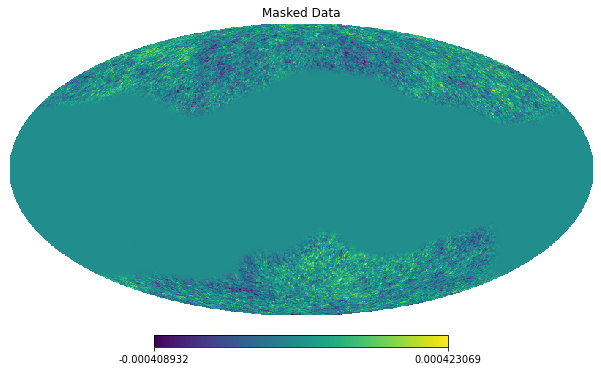

In [7]:
# Generate unmasked data
raw_data = generate_data(add_B=include_synthetic_b,add_T=include_synthetic_t)

# Mask the map
data = raw_data*mask

# Plot the data
healpy.mollview(data,title='Masked Data')

# Key Functions

### Creation of $U^{-1}$ weights 

**Ignoring pixel weights**, relation between discrete real- and harmonic-space is
$$a_{\ell m} = \frac{4\pi}{N}\sum_{p}Y_{\ell m}^*(\hat n_p)a(\hat n_p) \quad\leftrightarrow\quad a(\hat n_p) = \sum_{\ell m}Y_{\ell m}(\hat n_p)a_{\ell m}$$
for $N$ pixels.

Thus, the multiplication of two maps is given by
$$\frac{4\pi}{N}\sum_{p}a(\hat n_p)b(\hat n_p) = \sum_{\ell,m\geq 0}a_{\ell m}b^*_{\ell m}\left[1+\delta^{\rm K}_{m>0}\right]$$

We want to create a function $U^{-1}$ that satisfies $\int d\hat n'U^{-1}(\hat n,\hat n')\langle{u(\hat n')u(\hat n'')\rangle} = \delta_{\rm D}(\hat n-\hat n'')$ in continuous space, or, in discrete map-space: $\left(\frac{4\pi}{N}\right)^2\sum_{jk}U^{-1}(\hat n_i,\hat n_j)\langle u(\hat n_j)u(\hat n_k)\rangle \beta(\hat n_k) = \beta(\hat n_i)$ for arbitrary $\beta$ and GRFs $u$. This implies:
\begin{eqnarray}
    U^{-1}(\hat n_i,\hat n_j) =\sum_{\ell m}\frac{1}{C^u_{\ell}}Y_{\ell m}(\hat n_i)Y^*_{\ell m}(\hat n_j)
\end{eqnarray}
A good way to test this is by computing
$$\left(\frac{4\pi}{N}\right)^2\sum_{ij}u(\hat n_i)U^{-1}(\hat n_i,\hat n_j)u(\hat n_j)$$
which should equal $(\ell_{\rm max}+1)^2$, averaging over $u$.

In [8]:
av_sq_mask = np.mean(mask**2)
A_pix = 4.*np.pi/len(mask)
    
def applySinv(input_map):
    """Apply the optimal weighting to a map. 
    
    Here, we assume that the forward covariance is diagonal, in particular (C_l + N_l) and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but should be unbiased."""
    
    # Transform to harmonic space
    input_map_lm = to_lm(input_map)
    # Divide by covariance and return to map-space
    Cinv_map = to_map(safe_divide(input_map_lm,Cl_th_lm+Nl_th_lm))
    
    return Cinv_map

def generate_grf(seed):
    """Generate a Gaussian random field with a known (exact) power spectrum, and covariance U.
    
    Here, we assume that the power spectrum is diagonal in ell without a window."""
    # Set seed
    np.random.seed(seed)
    # Generate spectrum
    return healpy.synfast(Cl_th+Nl_th,Nside)

def applyUinv(input_map):
    """Apply the exact inverse weighting U^{-1} to a map."""
    
    # Transform to harmonic space
    input_map_lm = to_lm(input_map)
    # Divide by covariance and return to map-space
    output = to_map(safe_divide(input_map_lm,Cl_th_lm+Nl_th_lm))
    return output

def check_bin(bin1,bin2,bin3,even=False):
    """Return one if modes in the bin satisfy the triangle conditions, or zero else.
    
    This is used either for all triangles in the bin, or just the center of the bin.
    
    If `even = True`, we remove any odd-parity modes.
    """
    if include_partial_triangles:
        good = 0
        for l1 in range(min_l+bin1*dl,min_l+(bin1+1)*dl):
            for l2 in range(min_l+bin2*dl,min_l+(bin2+1)*dl):
                for l3 in range(min_l+bin3*dl,min_l+(bin3+1)*dl):
                    # skip any odd bins
                    if even and ((-1)**(l1+l2+l3)==-1): continue 
                    if l1>=abs(l1-l2) and l3<=l1+l2:
                        good = 1
                    if good==1: break
                if good==1: break
            if good==1: break
        if good==1: return 1
        else:
            return 0
    else:
        l1 = min_l+(bin1+0.5)*dl
        l2 = min_l+(bin2+0.5)*dl
        l3 = min_l+(bin3+0.5)*dl
        if even and ((-1)**(l1+l2+l3)==-1): return 0 
        if l3<abs(l1-l2) or l3>l1+l2:
            return 0
        else:
            return 1

In [9]:
# Define ell bins
ell_bins = [(l_arr>=min_l+dl*bin1)&(l_arr<min_l+dl*(bin1+1)) for bin1 in range(Nl)]

# Trispectrum estimation

### Definitions
$H$ maps are defined as
\begin{eqnarray}
    H^{\pm}_{b}(\hat n) &=& \sum_{\ell m}h_{\ell m}\Theta_\ell(b){}_{\pm1}Y_{\ell m}(\hat n)\\\nonumber
    \overline{H}^{\pm}_{b}(\hat n) &=& \sum_{\ell m}(-1)^\ell h_{\ell m}\Theta_\ell(b){}_{\pm1}Y_{\ell m}(\hat n).
\end{eqnarray}
These satisfy $(H^{\pm})^* = -H^{\mp}$. $A$ maps are given by
\begin{eqnarray}
    A_{b_1b_2}(L,M) &=& \int d\hat n\,{}_{-2}Y_{LM}(\hat n)H^+_{b_1}(\hat n)H^+_{b_2}(\hat n)\\\nonumber
    \overline{A}_{b_1b_2}(L,M) &=& (-1)^L\int d\hat n\,{}_{-2}Y_{LM}(\hat n)\overline{H}^{+}_{b_1}(\hat n)\overline{H}^{+}_{b_2}(\hat n),
\end{eqnarray}
These satisfy $A_{b_1b_2}^*(L,M) = (-1)^{M}\overline{A}_{b_1b_2}(L,-M)$.
 
For the parity-odd trispectrum, only the four-point term is non-vanishing, given by
\begin{eqnarray}
    \widehat{t}_4(\vec b, L) &\propto& -\frac{1}{6\Delta(\vec b)}\sum_{M}(-1)^M\left[A_{b_1b_2}(L,-M)A_{b_3b_4}(L,M)-\overline A_{b_1b_2}(L,-M)\overline A_{b_3b_4}(L,M)\right]\\
    &=&-\frac{1}{6\Delta(\vec b)}\sum_{M}\left[\overline{A}^*_{b_1b_2}(L,M)A_{b_3b_4}(L,M)-A^*_{b_1b_2}(L,M)\overline A_{b_3b_4}(L,M)\right]\\
    &=&-\frac{i}{6\Delta(\vec b)}\sum_{M\geq 0}\mathrm{Im}\left[\overline{A}^*_{b_1b_2}(L,M)A_{b_3b_4}(L,M)-A^*_{b_1b_2}(L,M)\overline A_{b_3b_4}(L,M)\right](1+\delta^{\rm K}_{M\geq 0}),
\end{eqnarray}

### Healpix conventions
Spin-spherical harmonic coefficients are defined as
$${}_sf(\hat{n}) = \sum_{\ell m}{}_sY_{\ell m}(\hat n){}_sf_{\ell m}$$

$${}_sf_{\ell m}=\int d\hat{n}\,{}_sY_{\ell m}^*(\hat n){}_sf(\hat n).$$

The HEALPix `alm2map_spin` routines require the following inputs:
$${}_{|s|}f_{\ell m}^{+} = -({}_{|s|}f_{\ell m}+(-1)^s_{-|s|}f_{\ell m})/2$$
$${}_{|s|}f_{\ell m}^{-} = -({}_{|s|}f_{\ell m}-(-1)^s_{-|s|}f_{\ell m})/(2i),$$
and produce the following maps:
$$_{|s|}f^+ = ({}_{|s|}f+{}_{-|s|}f)/2$$
$$_{|s|}f^- = ({}_{|s|}f-{}_{-|s|}f)/(2i)$$

### Our usage
To compute the $H$ maps, we first define a spin-$\pm1$ field ${}_{\pm1}H(\hat n) = \pm H^\pm(\hat n)$ (where $H^\pm(\hat n)$ is defined above), such that ${}_{\pm 1}H^* = {}_{\mp1}H_\pm$, giving the correct spin$-\pm1$ conjugation properties. This has the corresponding multipoles ${}_{\pm 1}H_{\ell m}=\pm h_{\ell m}\Theta_\ell(b)$. The relevant inputs to HEALPix are thus $$\{{}_{1}H_{\ell m}^{+}, {}_{1}H_{\ell m}^{-}\} = \{-h_{\ell m}\Theta_\ell(b),0\},$$ and the outputs can be reconstructed as
$$H^{\pm} = \pm({}_{1}H^+\pm i{}_{1}H^-),$$
where ${}_{1}H^{\pm}$ are the HEALPix `alm2map_spin` outputs. These satisfy the required parity condition $(H^{\pm})^*=-H^{\mp}$.


For the $A$ maps, we define a spin-$\pm 2$ field ${}_{\pm2}A_{b_1b_2}(\hat n) = H^{\pm}_{b_1}(\hat n)H^{\pm}_{b_2}(\hat n)$. The map we require is given by
$$
    A_{b_1b_2}(L,M) = \left[\int d\hat n\,{}_{-2}Y_{LM}^*(\hat n)H_{b_1}^-(\hat n)H_{b_2}^-(\hat n)\right]^* \equiv \left[{}_{-2}A_{b_1b_2,LM}\right]^*,
$$
in terms of the harmonic transform of ${}_{-2}A$. In HEALPix conventions, we require the input maps $\{{}_{2}A^+,{}_{2}A^-\} = \{({}_{+2}A+{}_{-2}A)/2,({}_{+2}A-{}_{-2}A)/(2i)\}$, and the required output can be obtained as
$$
    A_{b_1b_2}(L,M) = -\left[{}_{2}A^+_{b_1b_2,LM}-i{}_{2}A^-_{b_1b_2,LM}\right]^*.
$$

In [10]:
def to_map_spin1(input_lm_plus, input_lm_minus):
    """Convert (+-1)H_lm from harmonic-space to map-space, weighting by (+-1)Y_{lm}. See above for convention definitions.
    """
    
    # Define inputs
    H_inp = [-(input_lm_plus-input_lm_minus)/2.,-(input_lm_plus+input_lm_minus)/(2.0j)]
    
    # Perform transformation
    H_out = healpy.alm2map_spin(H_inp,Nside,1,lmax)
    
    # Reconstruct output
    H_plus = H_out[0]+1.0j*H_out[1]
    H_minus = -H_out[0]+1.0j*H_out[1]
    
    return H_plus, H_minus

def to_lm_spin2(input_map_plus,input_map_minus):
    """Convert (+-2)A from map-space to harmonic-space, weighting by (+-2)Y_{lm}. See above for convention definitions.
    """
    
    # Define inputs
    A_inp = [np.real((input_map_plus+input_map_minus)/2.), np.real((input_map_plus-input_map_minus)/(2.0j))]
    
    # Perform transformation
    A_out = healpy.map2alm_spin(A_inp,2,lmax)
    
    # Reconstruct output
    A_plus = -A_out[0]-1.0j*A_out[1]
    A_minus = -A_out[0]+1.0j*A_out[1]
    
    return A_plus, A_minus

## Conventional (binned) parity-odd estimator

In [11]:
hlm_raw = safe_divide(to_lm(raw_data),Cl_th_lm+Nl_th_lm)
hlm = safe_divide(to_lm(data),Cl_th_lm+Nl_th_lm)

def compute_H(h_lm):
    """Compute the H^+- map given H_lm. This calls the to_map_spin1 routine with the correct inputs."""
    H_plus, H_minus = to_map_spin1(h_lm,-1.0*h_lm)
    return [H_plus, H_minus]

# Compute H+ maps
print("Computing H+- maps")
H_map_raw = [compute_H(ell_bins[bin1]*hlm_raw) for bin1 in range(Nl)]
H_map = [compute_H(ell_bins[bin1]*hlm) for bin1 in range(Nl)]

# Compute bar H+ maps
phase_factor = (-1.)**l_arr
Hbar_map_raw = [compute_H(phase_factor*ell_bins[bin1]*hlm_raw) for bin1 in range(Nl)]
Hbar_map = [compute_H(phase_factor*ell_bins[bin1]*hlm) for bin1 in range(Nl)]

Computing H+- maps


In [12]:
# Define array of A maps (restricting to bin2 <= bin1, by symmetry)

def compute_Alm(H_maps,bin1,bin2,H2_maps=[]):
    """Compute the A(L,M) map given H^+- and bins. This calls the to_lm_spin2 routine with the correct inputs.
    
    Note, we can optionally use two different H fields here."""
    
    if len(H2_maps)==0:
        H2_maps = H_maps
    
    A_plus = H_maps[bin1][0]*H2_maps[bin2][0]
    A_minus = H_maps[bin1][1]*H2_maps[bin2][1]
    
    A_plus_lm, A_minus_lm = to_lm_spin2(A_plus, A_minus)
    
    return A_minus_lm.conj()

print("Computing A maps")
Alm_raw = [[compute_Alm(H_map_raw,bin1,bin2) for bin2 in range(bin1+1)] for bin1 in range(Nl)]
Alm = [[compute_Alm(H_map,bin1,bin2) for bin2 in range(bin1+1)] for bin1 in range(Nl)]
Abar_lm_raw = [[phase_factor*compute_Alm(Hbar_map_raw,bin1,bin2) for bin2 in range(bin1+1)] for bin1 in range(Nl)]
Abar_lm = [[phase_factor*compute_Alm(Hbar_map,bin1,bin2) for bin2 in range(bin1+1)] for bin1 in range(Nl)]

Computing A maps


### Numerator

In [13]:
print("Computing parity-odd trispectrum estimator")
t_num_ideal = []
t_num_ideal_raw = []
t_sym_factor = []

m_factor = 1.+1.*(m_arr>0.)

# iterate over bins with b2>=b1, b4>=b3, b3>=b1 and b4>b2 if b1=b3
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin1,Nl):
            for bin4 in range(bin3,Nl):
                if bin1==bin3 and bin4<=bin2: continue
                
                # Compute summands
                summand = m_factor*np.imag(Abar_lm[bin2][bin1].conj()*Alm[bin4][bin3] - Alm[bin2][bin1].conj()*Abar_lm[bin4][bin3])
                summand_raw = m_factor*np.imag(Abar_lm_raw[bin2][bin1].conj()*Alm_raw[bin4][bin3] - Alm_raw[bin2][bin1].conj()*Abar_lm_raw[bin4][bin3])
                
                # Iterate over L bins
                for binL in range(Nl):
                    # skip bins outside the triangle conditions
                    if not check_bin(bin1,bin2,binL,even=False): continue
                    if not check_bin(bin3,bin4,binL,even=False): continue

                    # compute symmetry factor
                    if bin1==bin2 and bin3==bin4 and bin1==bin3:
                        sym = 8
                    elif bin1==bin2 and bin3==bin4:
                        sym = 4
                    elif bin1==bin2:
                        sym = 2
                    elif bin3==bin4:
                        sym = 2
                    elif bin1==bin3 and bin2==bin4:
                        sym = 2
                    else:
                        sym = 1
                    t_sym_factor.append(sym)        
                    
                    # Compute estimator numerator
                    t_num_ideal.append(-1.0j/2.*np.sum(summand*ell_bins[binL])/sym)
                    t_num_ideal_raw.append(-1.0j/2.*np.sum(summand_raw*ell_bins[binL])/sym)

t_num_ideal = np.asarray(t_num_ideal)/np.mean(mask**4)
t_num_ideal_raw = np.asarray(t_num_ideal_raw)
                        
N_t = len(t_sym_factor)
print("Using %d bins"%N_t)

Computing parity-odd trispectrum estimator
Using 313 bins


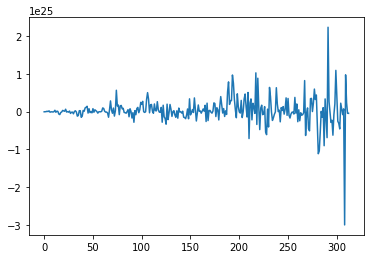

In [14]:
plt.plot(t_num_ideal.imag)

In [15]:
# Load pre-computed 3j symbols
assert lmax<=500, "Higher-l 3j symbols not yet precomputed!"
# load array of (-1, -1, 2) spin 3j symbols
tj_arr_spin = np.load('/projects/QUIJOTE/Oliver/wig3j_array_spin.npz')

# C+N vector
Sl_vec = [(li>=2)*(Cl_th_interp(li)+Nl_th_interp(li)) for li in l]

In [16]:
import pywigxjpf as wig
wig.wig_table_init(lmax*2,9)
wig.wig_temp_init(lmax*2)
sixj = lambda l1,l2,l3,l4,l5,l6: wig.wig6jj(2*l1,2*l2,2*l3,2*l4,2*l5,2*l6)

### Normalization Matrix

In [17]:
# compute denominator
print("Computing odd normalization matrix")
fish_odd = np.zeros((N_t,N_t))

# Iterate over first set of bins
index1 = -1
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin1,Nl):
            for bin4 in range(bin3,Nl):
                if bin1==bin3 and bin4<=bin2: continue
                for binL in range(Nl):
                    # skip bins outside the triangle conditions
                    if not check_bin(bin1,bin2,binL,even=False): continue
                    if not check_bin(bin3,bin4,binL,even=False): continue
                    index1 += 1
                    
                    if (index1+1)%5==0: print("Computing bin %d of %d"%(index1+1,N_t))
                    
                    # Iterate over second set of bins
                    index2 = -1
                    for bin1p in range(Nl):
                        for bin2p in range(bin1p,Nl):
                            for bin3p in range(bin1p,Nl):
                                for bin4p in range(bin3p,Nl):
                                    if bin1p==bin3p and bin4p<=bin2p: continue
                                    for binLp in range(Nl):
                                        # skip bins outside the triangle conditions
                                        if not check_bin(bin1p,bin2p,binLp,even=False): continue
                                        if not check_bin(bin3p,bin4p,binLp,even=False): continue
                                        index2 += 1

                                        ## Compute permutation factors
                                        pref1  = (bin1==bin1p)*(bin2==bin2p)*(bin3==bin3p)*(bin4==bin4p)*(binL==binLp)
                                        pref1 += (bin1==bin2p)*(bin2==bin1p)*(bin3==bin3p)*(bin4==bin4p)*(binL==binLp)
                                        pref1 += (bin1==bin1p)*(bin2==bin2p)*(bin3==bin4p)*(bin4==bin3p)*(binL==binLp)
                                        pref1 += (bin1==bin2p)*(bin2==bin1p)*(bin3==bin4p)*(bin4==bin3p)*(binL==binLp)
                                        pref1 += (bin1==bin3p)*(bin2==bin4p)*(bin3==bin1p)*(bin4==bin2p)*(binL==binLp)
                                        pref1 += (bin1==bin4p)*(bin2==bin3p)*(bin3==bin1p)*(bin4==bin2p)*(binL==binLp)
                                        pref1 += (bin1==bin3p)*(bin2==bin4p)*(bin3==bin2p)*(bin4==bin1p)*(binL==binLp)
                                        pref1 += (bin1==bin4p)*(bin2==bin3p)*(bin3==bin2p)*(bin4==bin1p)*(binL==binLp)

                                        pref2  = (bin1==bin1p)*(bin2==bin3p)*(bin3==bin2p)*(bin4==bin4p)
                                        pref2 += (bin1==bin2p)*(bin2==bin3p)*(bin3==bin1p)*(bin4==bin4p)
                                        pref2 += (bin1==bin1p)*(bin2==bin4p)*(bin3==bin2p)*(bin4==bin3p)
                                        pref2 += (bin1==bin2p)*(bin2==bin4p)*(bin3==bin1p)*(bin4==bin3p)
                                        pref2 += (bin1==bin3p)*(bin2==bin1p)*(bin3==bin4p)*(bin4==bin2p)
                                        pref2 += (bin1==bin3p)*(bin2==bin2p)*(bin3==bin4p)*(bin4==bin1p)
                                        pref2 += (bin1==bin4p)*(bin2==bin1p)*(bin3==bin3p)*(bin4==bin2p)
                                        pref2 += (bin1==bin4p)*(bin2==bin2p)*(bin3==bin3p)*(bin4==bin1p)
                                        
                                        pref3  = (bin1==bin1p)*(bin2==bin4p)*(bin3==bin3p)*(bin4==bin2p)
                                        pref3 += (bin1==bin2p)*(bin2==bin4p)*(bin3==bin3p)*(bin4==bin1p)
                                        pref3 += (bin1==bin1p)*(bin2==bin3p)*(bin3==bin4p)*(bin4==bin2p)
                                        pref3 += (bin1==bin2p)*(bin2==bin3p)*(bin3==bin4p)*(bin4==bin1p)
                                        pref3 += (bin1==bin3p)*(bin2==bin2p)*(bin3==bin1p)*(bin4==bin4p)
                                        pref3 += (bin1==bin3p)*(bin2==bin1p)*(bin3==bin2p)*(bin4==bin4p)
                                        pref3 += (bin1==bin4p)*(bin2==bin2p)*(bin3==bin1p)*(bin4==bin3p)
                                        pref3 += (bin1==bin4p)*(bin2==bin1p)*(bin3==bin2p)*(bin4==bin3p)
                                        
                                        if pref1+pref2+pref3==0: continue
                                            
                                        value = 0.

                                        # Now iterate over l bins
                                        for l1 in range(min_l+bin1*dl,min_l+(bin1+1)*dl):
                                            for l2 in range(min_l+bin2*dl,min_l+(bin2+1)*dl):
                                                for L in range(min_l+binL*dl,min_l+(binL+1)*dl):
                                                    # first 3j symbols with spin (-1, -1, 2)
                                                    tj12 = tj_arr_spin[l1,l2,L]
                                                    if L<abs(l1-l2) or L>l1+l2: continue
                                                    for l3 in range(min_l+bin3*dl,min_l+(bin3+1)*dl):
                                                        for l4 in range(min_l+bin4*dl,min_l+(bin4+1)*dl):
                                                            if L<abs(l3-l4) or L>l3+l4: continue
                                                            if (-1)**(l1+l2+l3+l4)==1: continue # remove parity-even

                                                            # second 3j symbols with spin (-1, -1, 2)
                                                            tj34 = tj_arr_spin[l3,l4,L]

                                                            ## add first permutation
                                                            if pref1!=0 and tj12*tj34!=0:
                                                                # assemble 3j contribution
                                                                value += -pref1*tj12**2*tj34**2*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)/(4.*np.pi)**2/Sl_vec[l1]/Sl_vec[l2]/Sl_vec[l3]/Sl_vec[l4]/t_sym_factor[index1]/t_sym_factor[index2]

                                                            for Lp in range(min_l+binLp*dl,min_l+(binLp+1)*dl):
                                                                tj1324 = tj_arr_spin[l1,l3,Lp]*tj_arr_spin[l2,l4,Lp]
                                                                tj1432 = tj_arr_spin[l1,l4,Lp]*tj_arr_spin[l3,l2,Lp]

                                                                ## add second permutation
                                                                if pref2!=0 and tj1324!=0: 
                                                                    value += -pref2*(-1.)**(l2+l3)*tj12*tj34*tj1324*sixj(L,l1,l2,Lp,l4,l3)*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)*(2.*Lp+1.)/(4.*np.pi)**2./Sl_vec[l1]/Sl_vec[l2]/Sl_vec[l3]/Sl_vec[l4]/t_sym_factor[index1]/t_sym_factor[index2]

                                                                ## add third permutation
                                                                if pref3!=0 and tj1432!=0:
                                                                    value += -pref3*(-1.)**(L+Lp)*tj12*tj34*tj1432*sixj(L,l1,l2,Lp,l3,l4)*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)*(2*Lp+1.)/(4.*np.pi)**2./Sl_vec[l1]/Sl_vec[l2]/Sl_vec[l3]/Sl_vec[l4]/t_sym_factor[index1]/t_sym_factor[index2]
                                                                    
                                        fish_odd[index1,index2] = value

Computing odd normalization matrix
Computing bin 5 of 313
Computing bin 10 of 313
Computing bin 15 of 313
Computing bin 20 of 313
Computing bin 25 of 313
Computing bin 30 of 313
Computing bin 35 of 313
Computing bin 40 of 313
Computing bin 45 of 313
Computing bin 50 of 313
Computing bin 55 of 313
Computing bin 60 of 313
Computing bin 65 of 313
Computing bin 70 of 313
Computing bin 75 of 313
Computing bin 80 of 313
Computing bin 85 of 313
Computing bin 90 of 313
Computing bin 95 of 313
Computing bin 100 of 313
Computing bin 105 of 313
Computing bin 110 of 313
Computing bin 115 of 313
Computing bin 120 of 313
Computing bin 125 of 313
Computing bin 130 of 313
Computing bin 135 of 313
Computing bin 140 of 313
Computing bin 145 of 313
Computing bin 150 of 313
Computing bin 155 of 313
Computing bin 160 of 313
Computing bin 165 of 313
Computing bin 170 of 313
Computing bin 175 of 313
Computing bin 180 of 313
Computing bin 185 of 313
Computing bin 190 of 313
Computing bin 195 of 313
Computing 

### Assemble estimate

In [18]:
inv_fish_odd = np.linalg.inv(fish_odd)
t_ideal_raw = inv_fish_odd@t_num_ideal_raw
t_ideal = inv_fish_odd@t_num_ideal

## Conventional (binned) parity-even estimator

### 4-field term

In [19]:
print("Computing parity-even trispectrum estimator")
t4e_num_ideal = []
t4e_num_ideal_raw = []
te_sym_factor = []

# iterate over bins with b2>=b1, b4>=b3, b3>=b1 and b4>=b2 if b1=b3
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin1,Nl):
            for bin4 in range(bin3,Nl):
                if bin1==bin3 and bin4<bin2: continue # note different condition to odd estimator!
                
                # Compute summands
                summand = m_factor*np.real(Abar_lm[bin2][bin1].conj()*Alm[bin4][bin3] + Alm[bin2][bin1].conj()*Abar_lm[bin4][bin3])
                summand_raw = m_factor*np.real(Abar_lm_raw[bin2][bin1].conj()*Alm_raw[bin4][bin3] + Alm_raw[bin2][bin1].conj()*Abar_lm_raw[bin4][bin3])
                
                # Iterate over L bins
                for binL in range(Nl):
                    # skip bins outside the triangle conditions
                    if not check_bin(bin1,bin2,binL,even=False): continue
                    if not check_bin(bin3,bin4,binL,even=False): continue

                    # compute symmetry factor
                    if bin1==bin2 and bin3==bin4 and bin1==bin3:
                        sym = 8
                    elif bin1==bin2 and bin3==bin4:
                        sym = 4
                    elif bin1==bin2:
                        sym = 2
                    elif bin3==bin4:
                        sym = 2
                    elif bin1==bin3 and bin2==bin4:
                        sym = 2
                    else:
                        sym = 1
                    te_sym_factor.append(sym)        
                    
                    # Compute estimator numerator
                    t4e_num_ideal.append(1./2.*np.sum(summand*ell_bins[binL])/sym)
                    t4e_num_ideal_raw.append(1./2.*np.sum(summand_raw*ell_bins[binL])/sym)

t4e_num_ideal = np.asarray(t4e_num_ideal)/np.mean(mask**4)
t4e_num_ideal_raw = np.asarray(t4e_num_ideal_raw)
                        
N_te = len(te_sym_factor)
print("Using %d bins"%N_te)

Computing parity-even trispectrum estimator
Using 371 bins


### 2-field and 0-field terms
\begin{eqnarray}
    \widehat{t}_2(\vec b,L) &\propto& -\frac{1}{\Delta(\vec b)}\sum_{\ell_1\ell_2m_2}\frac{(2\ell_1+1)(2L+1)}{4\pi}\begin{pmatrix}\ell_1 & \ell_2 & L\\ -1 & -1 & 2\end{pmatrix}^2\\\nonumber
    &&\,\times\,(-1)^{\ell_1+\ell_2+L}\left|h_{\ell_2m_2}\right|^2C_{\ell_1}^{-1}\left(\delta_{b_1b_3}^{\rm K}\delta_{b_2b_4}^{\rm K}+\delta_{b_1b_4}^{\rm K}\delta_{b_2b_3}^{\rm K}\right)\left(\Theta_{\ell_1}(b_1)\Theta_{\ell_2}(b_2)+\Theta_{\ell_1}(b_2)\Theta_{\ell_2}(b_1)\right)\\
    \widehat{t}_0(\vec b,L) &\propto& \frac{1}{\Delta(\vec b)}\sum_{\ell_1\ell_2m_2}\frac{(2\ell_1+1)(2L+1)}{4\pi}\begin{pmatrix}\ell_1 & \ell_2 & L\\ -1 & -1 & 2\end{pmatrix}^2\\\nonumber
    &&\,\times\,(-1)^{\ell_1+\ell_2+L}C_{\ell_1}^{-1}C_{\ell_2}^{-1}\left(\delta_{b_1b_3}^{\rm K}\delta_{b_2b_4}^{\rm K}+\delta_{b_1b_4}^{\rm K}\delta_{b_2b_3}^{\rm K}\right).
\end{eqnarray}


In [20]:
print("Computing two-point and zero-point terms")
t2e_num_ideal = []
t2e_num_ideal_raw = []
t0e_num_ideal = []
t0e_num_ideal_raw = []

hlm_sq = np.real(hlm*np.conj(hlm)*m_factor)
hlm_raw_sq = np.real(hlm_raw*np.conj(hlm_raw)*m_factor)

# iterate over bins with b2>=b1, b4>=b3, b3>=b1 and b4>=b2 if b1=b3
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin1,Nl):
            for bin4 in range(bin3,Nl):
                if bin1==bin3 and bin4<bin2: continue # note different condition to odd estimator!

                # Iterate over L bins
                for binL in range(Nl):
                    # skip bins outside the triangle conditions
                    if not check_bin(bin1,bin2,binL,even=False): continue
                    if not check_bin(bin3,bin4,binL,even=False): continue

                    # Check if two external bins are equal (if not, no contribution)
                    kroneckers = (bin1==bin3)*(bin2==bin4)+(bin1==bin4)*(bin2==bin3)
                    if kroneckers==0:
                        t2e_num_ideal.append(0.)
                        t2e_num_ideal_raw.append(0.)
                        t0e_num_ideal.append(0.)
                        t0e_num_ideal_raw.append(0.)
                        continue
                    
                    value2 = 0.
                    value2_raw = 0.
                    value0 = 0.
                    value0_raw = 0.

                    # Compute contribution, iterating over l bins
                    for l1 in range(min_l+bin1*dl,min_l+(bin1+1)*dl):

                        # Compute sum over l1
                        hsq_l1 = np.sum(hlm_sq[l_arr==l1])
                        hsq_raw_l1 = np.sum(hlm_raw_sq[l_arr==l1])

                        for l2 in range(min_l+bin2*dl,min_l+(bin2+1)*dl):

                            # Compute sum over l2
                            hsq_l2 = np.sum(hlm_sq[l_arr==l2])
                            hsq_raw_l2 = np.sum(hlm_raw_sq[l_arr==l2])

                            for L in range(min_l+binL*dl,min_l+(binL+1)*dl):
                                if L<abs(l1-l2) or L>l1+l2: continue

                                # define 3j symbols with spin (-1, -1, 2)
                                tjs = tj_arr_spin[l1,l2,L]**2.

                                # First contribution to sum
                                value2 += -1./(te_sym_factor[len(t2e_num_ideal)])*(2.*l1+1.)*(2.*L+1.)/(4.*np.pi)*tjs*(-1.)**(l1+l2+L)*hsq_l2/Sl_vec[l1]*kroneckers
                                # Contribution switching l1 and l2
                                value2 += -1./(te_sym_factor[len(t2e_num_ideal)])*(2.*l2+1.)*(2.*L+1.)/(4.*np.pi)*tjs*(-1.)**(l2+l1+L)*hsq_l1/Sl_vec[l2]*kroneckers

                                # 0-field contribution
                                value0 += 1./(te_sym_factor[len(t2e_num_ideal)])*(2.*l1+1.)*(2.*l2+1.)*(2.*L+1.)/(4.*np.pi)*tjs*(-1.)**(l1+l2+L)/Sl_vec[l1]/Sl_vec[l2]*kroneckers
                                
                                # Repeat for raw spectra
                                value2_raw += -1./(te_sym_factor[len(t2e_num_ideal)])*(2.*l1+1.)*(2.*L+1.)/(4.*np.pi)*tjs*(-1.)**(l1+l2+L)*hsq_raw_l2/Sl_vec[l1]*kroneckers
                                value2_raw += -1./(te_sym_factor[len(t2e_num_ideal)])*(2.*l2+1.)*(2.*L+1.)/(4.*np.pi)*tjs*(-1.)**(l2+l1+L)*hsq_raw_l1/Sl_vec[l2]*kroneckers
                                value0_raw += 1./(te_sym_factor[len(t2e_num_ideal)])*(2.*l1+1.)*(2.*l2+1.)*(2.*L+1.)/(4.*np.pi)*tjs*(-1.)**(l1+l2+L)/Sl_vec[l1]/Sl_vec[l2]*kroneckers
                                
                    # Add to output array
                    t2e_num_ideal.append(value2)
                    t2e_num_ideal_raw.append(value2_raw)
                    t0e_num_ideal.append(value0)
                    t0e_num_ideal_raw.append(value0_raw)
                    
# Define outputs (adding relevant mask factors)
t2e_num_ideal = np.asarray(t2e_num_ideal)/np.mean(mask**2) # NB: need to account for < W^2 > from < h h > before normalizing
t2e_num_ideal_raw = np.asarray(t2e_num_ideal_raw)
t0e_num_ideal = np.asarray(t0e_num_ideal)
t0e_num_ideal_raw = np.asarray(t0e_num_ideal_raw)

Computing two-point and zero-point terms


In [21]:
# compute denominator
print("Computing even normalization matrix")
fish_even = np.zeros((N_te,N_te))

# Iterate over first set of bins
index1 = -1
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin1,Nl):
            for bin4 in range(bin3,Nl):
                if bin1==bin3 and bin4<bin2: continue
                for binL in range(Nl):
                    # skip bins outside the triangle conditions
                    if not check_bin(bin1,bin2,binL,even=False): continue
                    if not check_bin(bin3,bin4,binL,even=False): continue
                    index1 += 1
                    
                    if (index1+1)%5==0: print("Computing bin %d of %d"%(index1+1,N_te))
                    
                    # Iterate over second set of bins
                    index2 = -1
                    for bin1p in range(Nl):
                        for bin2p in range(bin1p,Nl):
                            for bin3p in range(bin1p,Nl):
                                for bin4p in range(bin3p,Nl):
                                    if bin1p==bin3p and bin4p<bin2p: continue
                                    for binLp in range(Nl):
                                        # skip bins outside the triangle conditions
                                        if not check_bin(bin1p,bin2p,binLp,even=False): continue
                                        if not check_bin(bin3p,bin4p,binLp,even=False): continue
                                        index2 += 1

                                        ## Compute permutation factors
                                        pref1  = (bin1==bin1p)*(bin2==bin2p)*(bin3==bin3p)*(bin4==bin4p)*(binL==binLp)
                                        pref1 += (bin1==bin2p)*(bin2==bin1p)*(bin3==bin3p)*(bin4==bin4p)*(binL==binLp)
                                        pref1 += (bin1==bin1p)*(bin2==bin2p)*(bin3==bin4p)*(bin4==bin3p)*(binL==binLp)
                                        pref1 += (bin1==bin2p)*(bin2==bin1p)*(bin3==bin4p)*(bin4==bin3p)*(binL==binLp)
                                        pref1 += (bin1==bin3p)*(bin2==bin4p)*(bin3==bin1p)*(bin4==bin2p)*(binL==binLp)
                                        pref1 += (bin1==bin4p)*(bin2==bin3p)*(bin3==bin1p)*(bin4==bin2p)*(binL==binLp)
                                        pref1 += (bin1==bin3p)*(bin2==bin4p)*(bin3==bin2p)*(bin4==bin1p)*(binL==binLp)
                                        pref1 += (bin1==bin4p)*(bin2==bin3p)*(bin3==bin2p)*(bin4==bin1p)*(binL==binLp)

                                        pref2  = (bin1==bin1p)*(bin2==bin3p)*(bin3==bin2p)*(bin4==bin4p)
                                        pref2 += (bin1==bin2p)*(bin2==bin3p)*(bin3==bin1p)*(bin4==bin4p)
                                        pref2 += (bin1==bin1p)*(bin2==bin4p)*(bin3==bin2p)*(bin4==bin3p)
                                        pref2 += (bin1==bin2p)*(bin2==bin4p)*(bin3==bin1p)*(bin4==bin3p)
                                        pref2 += (bin1==bin3p)*(bin2==bin1p)*(bin3==bin4p)*(bin4==bin2p)
                                        pref2 += (bin1==bin3p)*(bin2==bin2p)*(bin3==bin4p)*(bin4==bin1p)
                                        pref2 += (bin1==bin4p)*(bin2==bin1p)*(bin3==bin3p)*(bin4==bin2p)
                                        pref2 += (bin1==bin4p)*(bin2==bin2p)*(bin3==bin3p)*(bin4==bin1p)
                                        
                                        pref3  = (bin1==bin1p)*(bin2==bin4p)*(bin3==bin3p)*(bin4==bin2p)
                                        pref3 += (bin1==bin2p)*(bin2==bin4p)*(bin3==bin3p)*(bin4==bin1p)
                                        pref3 += (bin1==bin1p)*(bin2==bin3p)*(bin3==bin4p)*(bin4==bin2p)
                                        pref3 += (bin1==bin2p)*(bin2==bin3p)*(bin3==bin4p)*(bin4==bin1p)
                                        pref3 += (bin1==bin3p)*(bin2==bin2p)*(bin3==bin1p)*(bin4==bin4p)
                                        pref3 += (bin1==bin3p)*(bin2==bin1p)*(bin3==bin2p)*(bin4==bin4p)
                                        pref3 += (bin1==bin4p)*(bin2==bin2p)*(bin3==bin1p)*(bin4==bin3p)
                                        pref3 += (bin1==bin4p)*(bin2==bin1p)*(bin3==bin2p)*(bin4==bin3p)
                                        
                                        if pref1+pref2+pref3==0: continue
                                            
                                        value = 0.

                                        # Now iterate over l bins
                                        for l1 in range(min_l+bin1*dl,min_l+(bin1+1)*dl):
                                            for l2 in range(min_l+bin2*dl,min_l+(bin2+1)*dl):
                                                for L in range(min_l+binL*dl,min_l+(binL+1)*dl):
                                                    # first 3j symbols with spin (-1, -1, 2)
                                                    tj12 = tj_arr_spin[l1,l2,L]
                                                    if L<abs(l1-l2) or L>l1+l2: continue
                                                    for l3 in range(min_l+bin3*dl,min_l+(bin3+1)*dl):
                                                        for l4 in range(min_l+bin4*dl,min_l+(bin4+1)*dl):
                                                            if L<abs(l3-l4) or L>l3+l4: continue
                                                            if (-1)**(l1+l2+l3+l4)==-1: continue # remove parity-odd

                                                            # second 3j symbols with spin (-1, -1, 2)
                                                            tj34 = tj_arr_spin[l3,l4,L]

                                                            ## add first permutation
                                                            if pref1!=0 and tj12*tj34!=0:
                                                                # assemble 3j contribution
                                                                value += pref1*tj12**2*tj34**2*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)/(4.*np.pi)**2/Sl_vec[l1]/Sl_vec[l2]/Sl_vec[l3]/Sl_vec[l4]/te_sym_factor[index1]/te_sym_factor[index2]

                                                            for Lp in range(min_l+binLp*dl,min_l+(binLp+1)*dl):
                                                                tj1324 = tj_arr_spin[l1,l3,Lp]*tj_arr_spin[l2,l4,Lp]
                                                                tj1432 = tj_arr_spin[l1,l4,Lp]*tj_arr_spin[l3,l2,Lp]

                                                                ## add second permutation
                                                                if pref2!=0 and tj1324!=0: 
                                                                    value += pref2*(-1.)**(l2+l3)*tj12*tj34*tj1324*sixj(L,l1,l2,Lp,l4,l3)*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)*(2.*Lp+1.)/(4.*np.pi)**2./Sl_vec[l1]/Sl_vec[l2]/Sl_vec[l3]/Sl_vec[l4]/te_sym_factor[index1]/te_sym_factor[index2]

                                                                ## add third permutation
                                                                if pref3!=0 and tj1432!=0:
                                                                    value += pref3*(-1.)**(L+Lp)*tj12*tj34*tj1432*sixj(L,l1,l2,Lp,l3,l4)*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)*(2.*l4+1.)*(2.*L+1.)*(2*Lp+1.)/(4.*np.pi)**2./Sl_vec[l1]/Sl_vec[l2]/Sl_vec[l3]/Sl_vec[l4]/te_sym_factor[index1]/te_sym_factor[index2]
                                                                    
                                        fish_even[index1,index2] = value

Computing even normalization matrix
Computing bin 5 of 371
Computing bin 10 of 371
Computing bin 15 of 371
Computing bin 20 of 371
Computing bin 25 of 371
Computing bin 30 of 371
Computing bin 35 of 371
Computing bin 40 of 371
Computing bin 45 of 371
Computing bin 50 of 371
Computing bin 55 of 371
Computing bin 60 of 371
Computing bin 65 of 371
Computing bin 70 of 371
Computing bin 75 of 371
Computing bin 80 of 371
Computing bin 85 of 371
Computing bin 90 of 371
Computing bin 95 of 371
Computing bin 100 of 371
Computing bin 105 of 371
Computing bin 110 of 371
Computing bin 115 of 371
Computing bin 120 of 371
Computing bin 125 of 371
Computing bin 130 of 371
Computing bin 135 of 371
Computing bin 140 of 371
Computing bin 145 of 371
Computing bin 150 of 371
Computing bin 155 of 371
Computing bin 160 of 371
Computing bin 165 of 371
Computing bin 170 of 371
Computing bin 175 of 371
Computing bin 180 of 371
Computing bin 185 of 371
Computing bin 190 of 371
Computing bin 195 of 371
Computing

In [22]:
te_num_ideal_raw = t4e_num_ideal_raw+t2e_num_ideal_raw+t0e_num_ideal_raw
te_num_ideal = t4e_num_ideal+t2e_num_ideal+t0e_num_ideal

inv_fish_even = np.linalg.inv(fish_even)
te_ideal_raw = inv_fish_even@te_num_ideal_raw
te_ideal = inv_fish_even@te_num_ideal

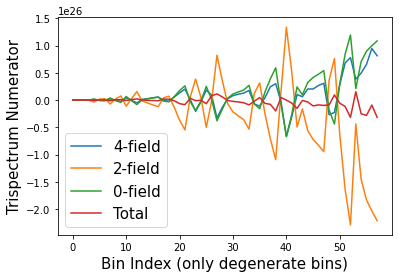

In [23]:
filt = t2e_num_ideal!=0
plt.plot(t4e_num_ideal[filt],label='4-field')
plt.plot(t2e_num_ideal[filt],label='2-field')
plt.plot(t0e_num_ideal[filt],label='0-field')
plt.plot((t4e_num_ideal+t2e_num_ideal+t0e_num_ideal)[filt],label='Total')
plt.xlabel(r'Bin Index (only degenerate bins)',fontsize=15)
plt.ylabel(r'Trispectrum Numerator',fontsize=15)
plt.legend(fontsize=15)

### Plot Trispectra

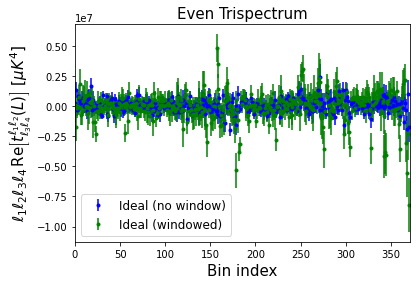

In [24]:
te_weights = []
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin1,Nl):
            for bin4 in range(bin3,Nl):
                if bin1==bin3 and bin4<bin2: continue
                for binL in range(Nl):
                    # skip bins outside the triangle conditions
                    if not check_bin(bin1,bin2,binL,even=False): continue
                    if not check_bin(bin3,bin4,binL,even=False): continue
                    l1, l2, l3, l4 = (min_l+(bin1+0.5)*dl),(min_l+(bin2+0.5)*dl),(min_l+(bin3+0.5)*dl),(min_l+(bin4+0.5)*dl)
                    te_weights.append(l1*l2*l3*l4*1e24)
te_weights = np.asarray(te_weights)
            
fish_err_ideal_e = np.sqrt(np.diag(inv_fish_even))
plt.errorbar(np.arange(N_te),te_weights*te_ideal_raw.real,yerr=te_weights*fish_err_ideal_e,marker='.',ls='',label='Ideal (no window)',c='b')
plt.errorbar(np.arange(N_te),te_weights*te_ideal.real,yerr=te_weights*fish_err_ideal_e*np.mean(mask**8)**0.5/np.mean(mask**4),marker='.',ls='',label='Ideal (windowed)',c='g')
if include_synthetic_t:
    plt.plot(np.arange(N_te),te_weights*te_model*include_synthetic_t,label='Theory model',c='r')
plt.xlim([0,N_te])
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3\ell_4\,\mathrm{Re}\left[t^{\ell_1\ell_2}_{\ell_3\ell_4}(L)\right]\,\,[\mu K^4]$',fontsize=15)
plt.legend(fontsize=12)
plt.title('Even Trispectrum',fontsize=15);

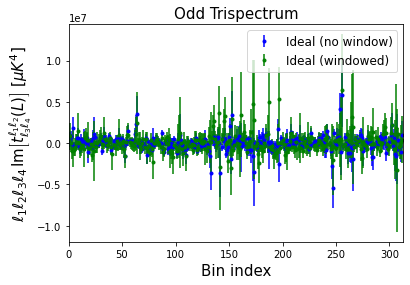

In [25]:
t_weights = []
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin1,Nl):
            for bin4 in range(bin3,Nl):
                if bin1==bin3 and bin4<=bin2: continue
                for binL in range(Nl):
                    # skip bins outside the triangle conditions
                    if not check_bin(bin1,bin2,binL,even=False): continue
                    if not check_bin(bin3,bin4,binL,even=False): continue
                    t_weights.append((min_l+(bin1+0.5)*dl)*(min_l+(bin2+0.5)*dl)*(min_l+(bin3+0.5)*dl)*(min_l+(bin4+0.5)*dl)*1e24)
t_weights = np.asarray(t_weights)
            
fish_err_ideal = np.sqrt(np.diag(-inv_fish_odd))
plt.errorbar(np.arange(N_t),t_weights*t_ideal_raw.imag,yerr=t_weights*fish_err_ideal,marker='.',ls='',label='Ideal (no window)',c='b')
plt.errorbar(np.arange(N_t),t_weights*t_ideal.imag,yerr=t_weights*fish_err_ideal*np.mean(mask**8)**0.5/np.mean(mask**4),marker='.',ls='',label='Ideal (windowed)',c='g')
if include_synthetic_t:
    plt.plot(np.arange(N_t),t_weights*tl_model*include_synthetic_t,label='Theory model',c='r')
plt.xlim([0,N_t])
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3\ell_4\,\mathrm{Im}\left[t^{\ell_1\ell_2}_{\ell_3\ell_4}(L)\right]\,\,[\mu K^4]$',fontsize=15)
plt.legend(fontsize=12)
plt.title('Odd Trispectrum',fontsize=15);

## Iterate over Monte Carlo realizations

In [26]:
t_odds = []
t_odds_raw = []
t_evens = []
t_evens_raw = []

for jj in range(N_sim):
    if jj%5==0: print("Analyzing realization %d of %d"%(jj+1,N_sim))
    
    # Create maps
    raw_data = generate_data(jj+int(1e6),include_synthetic_b,include_synthetic_t)
    data = raw_data*mask
    
    # Create H fields
    hlm = safe_divide(to_lm(data),Cl_th_lm+Nl_th_lm)
    hlm_sq = np.real(hlm*np.conj(hlm)*m_factor)
    hlm_raw = safe_divide(to_lm(raw_data),Cl_th_lm+Nl_th_lm)
    hlm_sq_raw = np.real(hlm_raw*np.conj(hlm_raw)*m_factor)
    
    # Compute H+ maps
    if jj==0: print("Computing H+- maps")
    H_map = [compute_H(ell_bins[bin1]*hlm) for bin1 in range(Nl)]
    Hbar_map = [compute_H(phase_factor*ell_bins[bin1]*hlm) for bin1 in range(Nl)]
    H_map_raw = [compute_H(ell_bins[bin1]*hlm_raw) for bin1 in range(Nl)]
    Hbar_map_raw = [compute_H(phase_factor*ell_bins[bin1]*hlm_raw) for bin1 in range(Nl)]
    
    if jj==0: print("Computing A maps")
    Alm = [[compute_Alm(H_map,bin1,bin2) for bin2 in range(bin1+1)] for bin1 in range(Nl)]
    Abar_lm = [[phase_factor*compute_Alm(Hbar_map,bin1,bin2) for bin2 in range(bin1+1)] for bin1 in range(Nl)]
    Alm_raw = [[compute_Alm(H_map_raw,bin1,bin2) for bin2 in range(bin1+1)] for bin1 in range(Nl)]
    Abar_lm_raw = [[phase_factor*compute_Alm(Hbar_map_raw,bin1,bin2) for bin2 in range(bin1+1)] for bin1 in range(Nl)]
    
    if jj==0: print("Computing parity-odd trispectrum estimator")
    t_nums = []
    t_nums_raw = []

    # iterate over bins with b2>=b1, b4>=b3, b3>=b1 and b4>b2 if b1=b3
    for bin1 in range(Nl):
        for bin2 in range(bin1,Nl):
            for bin3 in range(bin1,Nl):
                for bin4 in range(bin3,Nl):
                    if bin1==bin3 and bin4<=bin2: continue
                
                    # Compute summands
                    summand = m_factor*np.imag(Abar_lm[bin2][bin1].conj()*Alm[bin4][bin3] - Alm[bin2][bin1].conj()*Abar_lm[bin4][bin3])
                    summand_raw = m_factor*np.imag(Abar_lm_raw[bin2][bin1].conj()*Alm_raw[bin4][bin3] - Alm_raw[bin2][bin1].conj()*Abar_lm_raw[bin4][bin3])
                    
                    # Iterate over L bins
                    for binL in range(Nl):
                        # skip bins outside the triangle conditions
                        if not check_bin(bin1,bin2,binL,even=False): continue
                        if not check_bin(bin3,bin4,binL,even=False): continue

                        # Compute estimator numerator
                        t_nums.append(-1.0j/2.*np.sum(summand*ell_bins[binL])/t_sym_factor[len(t_nums)])
                        t_nums_raw.append(-1.0j/2.*np.sum(summand_raw*ell_bins[binL])/t_sym_factor[len(t_nums_raw)])
                        
    t_odds.append(inv_fish_odd@np.asarray(t_nums)/np.mean(mask**4))
    t_odds_raw.append(inv_fish_odd@np.asarray(t_nums_raw))
    
    if jj==0: print("Computing parity-even trispectrum estimator")
    te_nums = []
    te_nums_raw = []

    # iterate over bins with b2>=b1, b4>=b3, b3>=b1 and b4>=b2 if b1=b3
    for bin1 in range(Nl):
        for bin2 in range(bin1,Nl):
            for bin3 in range(bin1,Nl):
                for bin4 in range(bin3,Nl):
                    if bin1==bin3 and bin4<bin2: continue # note different condition to odd estimator!

                    # Compute summands
                    summand = m_factor*np.real(Abar_lm[bin2][bin1].conj()*Alm[bin4][bin3] + Alm[bin2][bin1].conj()*Abar_lm[bin4][bin3])
                    summand_raw = m_factor*np.real(Abar_lm_raw[bin2][bin1].conj()*Alm_raw[bin4][bin3] + Alm_raw[bin2][bin1].conj()*Abar_lm_raw[bin4][bin3])
                    
                    # Iterate over L bins
                    for binL in range(Nl):
                        # skip bins outside the triangle conditions
                        if not check_bin(bin1,bin2,binL,even=False): continue
                        if not check_bin(bin3,bin4,binL,even=False): continue

                        # Compute estimator numerator
                        t4 = 1./2.*np.sum(summand*ell_bins[binL])/te_sym_factor[len(te_nums)]
                        t4_raw = 1./2.*np.sum(summand_raw*ell_bins[binL])/te_sym_factor[len(te_nums)]
                        
                        # Compute t2
                        kroneckers = (bin1==bin3)*(bin2==bin4)+(bin1==bin4)*(bin2==bin3)
                        t0, t2, t2_raw = 0, 0, 0
                        if kroneckers!=0:

                            # Compute contribution, iterating over l bins
                            for l1 in range(min_l+bin1*dl,min_l+(bin1+1)*dl):

                                # Compute sum over l1
                                hsq_l1 = np.sum(hlm_sq[l_arr==l1])
                                hsq_l1_raw = np.sum(hlm_sq_raw[l_arr==l1])

                                for l2 in range(min_l+bin2*dl,min_l+(bin2+1)*dl):

                                    # Compute sum over l2
                                    hsq_l2 = np.sum(hlm_sq[l_arr==l2])
                                    hsq_l2_raw = np.sum(hlm_sq_raw[l_arr==l2])

                                    for L in range(min_l+binL*dl,min_l+(binL+1)*dl):
                                        if L<abs(l1-l2) or L>l1+l2: continue

                                        # define 3j symbols with spin (-1, -1, 2)
                                        tjs = tj_arr_spin[l1,l2,L]**2.

                                        # First contribution to sum
                                        t2 += -1./(te_sym_factor[len(te_nums)])*(2.*l1+1.)*(2.*L+1.)/(4.*np.pi)*tjs*(-1.)**(l1+l2+L)*hsq_l2/Sl_vec[l1]*kroneckers
                                        t2_raw += -1./(te_sym_factor[len(te_nums)])*(2.*l1+1.)*(2.*L+1.)/(4.*np.pi)*tjs*(-1.)**(l1+l2+L)*hsq_l2_raw/Sl_vec[l1]*kroneckers
                                        # Contribution switching l1 and l2
                                        t2 += -1./(te_sym_factor[len(te_nums)])*(2.*l2+1.)*(2.*L+1.)/(4.*np.pi)*tjs*(-1.)**(l1+l2+L)*hsq_l1/Sl_vec[l2]*kroneckers
                                        t2_raw += -1./(te_sym_factor[len(te_nums)])*(2.*l2+1.)*(2.*L+1.)/(4.*np.pi)*tjs*(-1.)**(l1+l2+L)*hsq_l1_raw/Sl_vec[l2]*kroneckers
                                        
                                        # 0-field contribution
                                        t0 += 1./(te_sym_factor[len(te_nums)])*(2.*l1+1.)*(2.*l2+1.)*(2.*L+1.)/(4.*np.pi)*tjs*(-1.)**(l1+l2+L)/Sl_vec[l1]/Sl_vec[l2]*kroneckers
                    
                        te_nums.append(t4/np.mean(mask**4)+t2/np.mean(mask**2)+t0)
                        te_nums_raw.append(t4_raw+t2_raw+t0)
    t_evens.append(inv_fish_even@np.asarray(te_nums))
    t_evens_raw.append(inv_fish_even@np.asarray(te_nums_raw))

Analyzing realization 1 of 500
Computing H+- maps
Computing A maps
Computing parity-odd trispectrum estimator
Computing parity-even trispectrum estimator
Analyzing realization 6 of 500
Analyzing realization 11 of 500
Analyzing realization 16 of 500
Analyzing realization 21 of 500
Analyzing realization 26 of 500
Analyzing realization 31 of 500
Analyzing realization 36 of 500
Analyzing realization 41 of 500
Analyzing realization 46 of 500
Analyzing realization 51 of 500
Analyzing realization 56 of 500
Analyzing realization 61 of 500
Analyzing realization 66 of 500
Analyzing realization 71 of 500
Analyzing realization 76 of 500
Analyzing realization 81 of 500
Analyzing realization 86 of 500
Analyzing realization 91 of 500
Analyzing realization 96 of 500
Analyzing realization 101 of 500
Analyzing realization 106 of 500
Analyzing realization 111 of 500
Analyzing realization 116 of 500
Analyzing realization 121 of 500
Analyzing realization 126 of 500
Analyzing realization 131 of 500
Analyzin

### Plot spectra

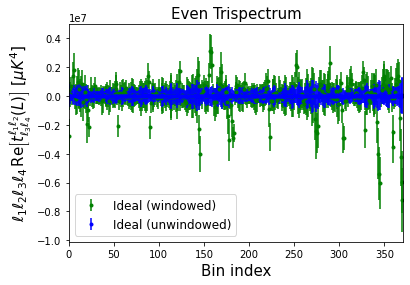

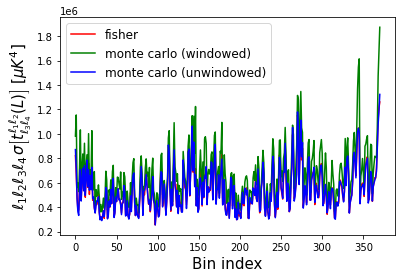

In [27]:
fish_err_ideal_e = np.sqrt(np.diag(inv_fish_even))

plt.errorbar(np.arange(N_te),te_weights*np.asarray(t_evens).mean(axis=0).real,yerr=te_weights*fish_err_ideal_e*np.mean(mask**8)**0.5/np.mean(mask**4),marker='.',ls='',label='Ideal (windowed)',c='g')
plt.errorbar(np.arange(N_te),te_weights*np.asarray(t_evens_raw).mean(axis=0).real,yerr=te_weights*fish_err_ideal_e,marker='.',ls='',label='Ideal (unwindowed)',c='b')
plt.xlim([0,N_te])
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3\ell_4\,\mathrm{Re}\left[t^{\ell_1\ell_2}_{\ell_3\ell_4}(L)\right]\,\,[\mu K^4]$',fontsize=15)
plt.legend(fontsize=12)
plt.title('Even Trispectrum',fontsize=15);

plt.figure()
plt.plot(np.arange(N_te),te_weights*fish_err_ideal_e,label='fisher',c='r')
plt.plot(np.arange(N_te),te_weights*np.asarray(t_evens).std(axis=0).real,label='monte carlo (windowed)',c='g')
plt.plot(np.arange(N_te),te_weights*np.asarray(t_evens_raw).std(axis=0).real,label='monte carlo (unwindowed)',c='b')
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3\ell_4\,\sigma\left[t^{\ell_1\ell_2}_{\ell_3\ell_4}(L)\right]\,\,[\mu K^4]$',fontsize=15)
plt.legend(fontsize=12);

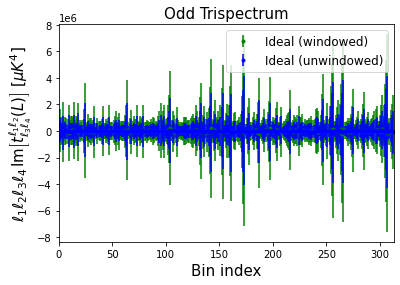

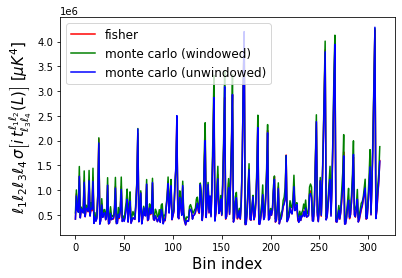

In [28]:
fish_err_ideal = np.sqrt(-np.diag(inv_fish_odd))

plt.errorbar(np.arange(N_t),t_weights*np.asarray(t_odds).mean(axis=0).imag,yerr=t_weights*fish_err_ideal*np.mean(mask**8)**0.5/np.mean(mask**4),marker='.',ls='',label='Ideal (windowed)',c='g')
plt.errorbar(np.arange(N_t),t_weights*np.asarray(t_odds_raw).mean(axis=0).imag,yerr=t_weights*fish_err_ideal,marker='.',ls='',label='Ideal (unwindowed)',c='b')
plt.xlim([0,N_t])
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3\ell_4\,\mathrm{Im}\left[t^{\ell_1\ell_2}_{\ell_3\ell_4}(L)\right]\,\,[\mu K^4]$',fontsize=15)
plt.legend(fontsize=12)
plt.title('Odd Trispectrum',fontsize=15);

plt.figure()
plt.plot(np.arange(N_t),t_weights*fish_err_ideal,label='fisher',c='r')
plt.plot(np.arange(N_t),t_weights*np.asarray(t_odds).std(axis=0).real,label='monte carlo (windowed)',c='g')
plt.plot(np.arange(N_t),t_weights*np.asarray(t_odds_raw).std(axis=0).real,label='monte carlo (unwindowed)',c='b')
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3\ell_4\,\sigma\left[i\,t^{\ell_1\ell_2}_{\ell_3\ell_4}(L)\right]\,\,[\mu K^4]$',fontsize=15)
plt.legend(fontsize=12);

### Plot correlation matrices

Text(0.5, 1.0, 'Even Trispectrum: Theory')

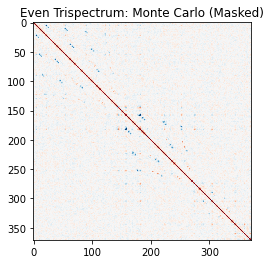

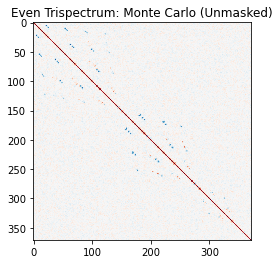

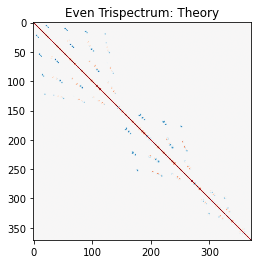

In [29]:
cov_raw = np.cov(np.asarray(t_evens_raw).real.T)
corr_raw = cov_raw/np.sqrt(np.outer(np.diag(cov_raw),np.diag(cov_raw)))
cov = np.cov(np.asarray(t_evens).real.T)
corr = cov/np.sqrt(np.outer(np.diag(cov),np.diag(cov)))
th_corr = inv_fish_even/np.sqrt(np.outer(np.diag(inv_fish_even),np.diag(inv_fish_even)))
v = 0.5
plt.imshow(corr,vmax=v,vmin=-v,cmap=cm.RdBu_r)
plt.title("Even Trispectrum: Monte Carlo (Masked)")
plt.figure()
plt.imshow(corr_raw,vmax=v,vmin=-v,cmap=cm.RdBu_r)
plt.title("Even Trispectrum: Monte Carlo (Unmasked)")
plt.figure()
plt.imshow(th_corr,vmax=v,vmin=-v,cmap=cm.RdBu_r)
plt.title("Even Trispectrum: Theory")

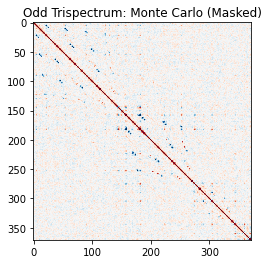

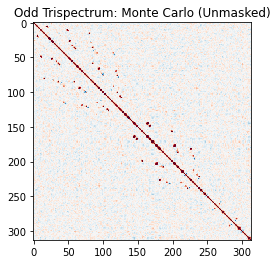

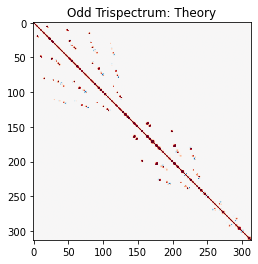

In [30]:
cov_raw = np.cov(np.asarray(t_odds_raw).imag.T)
corr_raw = cov_raw/np.sqrt(np.outer(np.diag(cov_raw),np.diag(cov_raw)))
cov = np.cov(np.asarray(t_evens).real.T)
corr = cov/np.sqrt(np.outer(np.diag(cov),np.diag(cov)))
corr = cov/np.sqrt(np.outer(np.diag(cov),np.diag(cov)))
th_corr = -inv_fish_odd/np.sqrt(np.outer(np.diag(inv_fish_odd),np.diag(inv_fish_odd)))
v = 0.3
plt.imshow(corr,vmax=v,vmin=-v,cmap=cm.RdBu_r)
plt.title("Odd Trispectrum: Monte Carlo (Masked)")
plt.figure()
plt.imshow(corr_raw,vmax=v,vmin=-v,cmap=cm.RdBu_r)
plt.title("Odd Trispectrum: Monte Carlo (Unmasked)")
plt.figure()
plt.imshow(th_corr,vmax=v,vmin=-v,cmap=cm.RdBu_r)
plt.title("Odd Trispectrum: Theory");

# TODO
- Test with true spectrum?
- Add non-ideal estimator